# Binary classification
---------------------------------

This example shows how we can use ATOM to perform a variety of data cleaning steps in order to prepare the data for modelling. Then, we compare the performances of two tree-based models.

The data used is a variation on the Australian weather dataset from [https://www.kaggle.com/jsphyg/weather-dataset-rattle-package](https://www.kaggle.com/jsphyg/weather-dataset-rattle-package). The goal of this dataset is to predict whether or not it will rain tomorrow training a binay classifier on target `RainTomorrow`.

## Load the data

In [1]:
# Import packages
import pandas as pd
from atom import ATOMClassifier

In [2]:
# Load data
X = pd.read_csv('./datasets/weatherAUS.csv')

# Let's have a look at the data
X.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


## Run the pipeline

In [3]:
# Call ATOM using only 5% of the complete dataset (for explanatory purposes)
atom = ATOMClassifier(X, 'RainTomorrow', n_rows=0.05, n_jobs=8, warnings=False, verbose=2, random_state=1)

<< ================== ATOM ================== >>
Algorithm task: binary classification.
Parallel processing with 8 cores.

Dataset stats ================== >>
Shape: (7110, 22)
Missing values: 15896
Categorical columns: 5
Scaled: False
-----------------------------------
Train set size: 5688
Test set size: 1422
-----------------------------------
Train set balance: No:Yes <==> 3.7:1.0
Test set balance: No:Yes <==> 4.1:1.0
-----------------------------------
Distribution of classes:
|     |   dataset |   train |   test |
|:----|----------:|--------:|-------:|
| No  |      5615 |    4473 |   1142 |
| Yes |      1495 |    1215 |    280 |



In [4]:
# Encode the target column
atom.clean()

Applying data cleaning...
 --> Label-encoding the target column.


In [5]:
# Impute missing values
atom.impute(strat_num='knn', strat_cat='drop', min_frac_rows=0.8)

Fitting Imputer...
Imputing missing values...
 --> Dropping 774 rows for containing less than 80% non-missing values.
 --> Imputing 7 missing values using the KNN imputer in feature MinTemp.
 --> Imputing 5 missing values using the KNN imputer in feature MaxTemp.
 --> Imputing 33 missing values using the KNN imputer in feature Rainfall.
 --> Imputing 2315 missing values using the KNN imputer in feature Evaporation.
 --> Imputing 2648 missing values using the KNN imputer in feature Sunshine.
 --> Dropping 202 rows due to missing values in feature WindGustDir.
 --> Dropping 358 rows due to missing values in feature WindDir9am.
 --> Dropping 15 rows due to missing values in feature WindDir3pm.
 --> Imputing 17 missing values using the KNN imputer in feature Humidity9am.
 --> Imputing 54 missing values using the KNN imputer in feature Humidity3pm.
 --> Imputing 37 missing values using the KNN imputer in feature Pressure9am.
 --> Imputing 34 missing values using the KNN imputer in feature P

In [6]:
# Encode the categorical features
atom.encode(strategy='CatBoost', max_onehot=10, frac_to_other=0.04)

Fitting Encoder...
Encoding categorical columns...
 --> CatBoost-encoding feature Location. Contains 1 unique classes.
 --> CatBoost-encoding feature WindGustDir. Contains 16 unique classes.
 --> CatBoost-encoding feature WindDir9am. Contains 16 unique classes.
 --> CatBoost-encoding feature WindDir3pm. Contains 16 unique classes.
 --> Label-encoding feature RainToday. Contains 2 unique classes.


In [7]:
# Fit the EXtra-Trees and Random Forest to the data
atom.run(models=['et', 'rf'], metric='f1', bagging=5, verbose=1)


Training ===================================== >>
Models: ET, RF
Metric: f1


Results for Extra-Trees:         
Fit ---------------------------------------------
Train evaluation --> f1: 1.0
Test evaluation --> f1: 0.5568
Time elapsed: 0.254s
Bagging -----------------------------------------
Evaluation --> f1: 0.5809 ± 0.0211
Time elapsed: 0.977s
-------------------------------------------------
Total time: 1.233s


Results for Random Forest:         
Fit ---------------------------------------------
Train evaluation --> f1: 1.0
Test evaluation --> f1: 0.594
Time elapsed: 0.311s
Bagging -----------------------------------------
Evaluation --> f1: 0.5977 ± 0.0134
Time elapsed: 1.356s
-------------------------------------------------
Total time: 1.668s


Final results ========================= >>
Duration: 2.901s
------------------------------------------
Extra-Trees   --> f1: 0.581 ± 0.021 ~
Random Forest --> f1: 0.598 ± 0.013 ~


## Analyze the results

In [8]:
# Let's have a look at the final scoring
atom.scoring()

# The winning model is indicated with a ! and can be accessed through the winner attribute
# The ~ indicates that the model is probably overfitting. If we look at the train and test
# score we see a difference of more than 20%
print(f'\n\nAnd the winner is the {atom.winner.fullname} model!!')
print('Score on the training set: ', atom.winner.metric_train)
print('Score on the test set: ', atom.winner.metric_test)

Extra-Trees   --> f1: 0.581 ± 0.021 ~
Random Forest --> f1: 0.598 ± 0.013 ~


And the winner is the Random Forest model!!
Score on the training set:  1.0
Score on the test set:  0.5940054495912807


**We can make many plots to check the performance of the models**

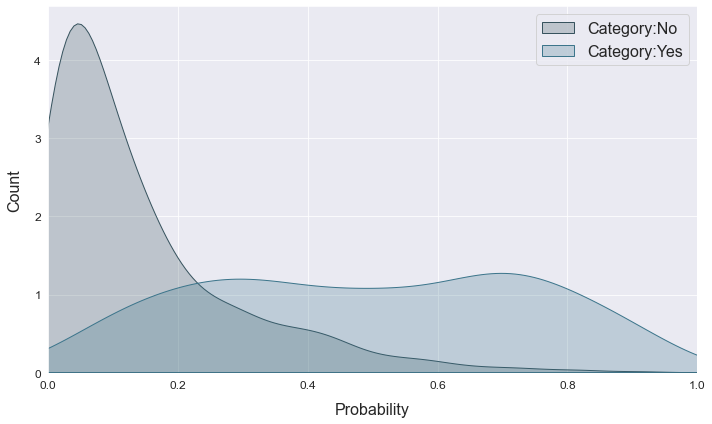

In [9]:
# The probabilties plot shows the distribution of predicted
# probabilities for the positive class
atom.winner.plot_probabilities()

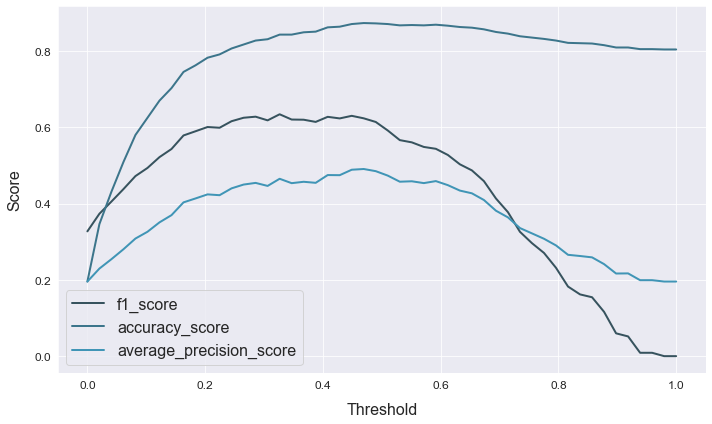

In [10]:
# The threshold plot let us compare how different metrics
# perform for different thresholds
atom.winner.plot_threshold(metric=['f1', 'accuracy', 'average_precision'], steps=50, filename='thresholds.png')

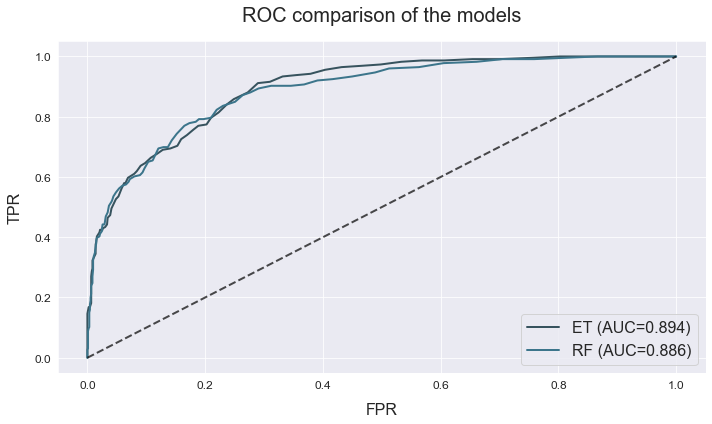

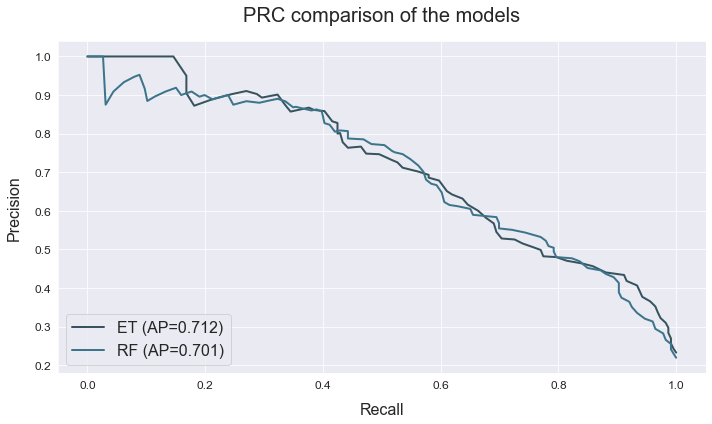

In [11]:
# The ROC and PRC curve are also typical ways of measuring performance 
atom.plot_roc(title="ROC comparison of the models")
atom.plot_prc(title="PRC comparison of the models")